In [1]:
import time
import gym
import numpy as np
import control as ct
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import matplotlib.pyplot as plt
import os


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [32]:
tf.reset_default_graph()
with tf.Session() as sess:
    a = tf.Variable(tf.zeros([10,4], dtype = tf.float32))
    sess.run(tf.global_variables_initializer())
    print(a.eval())
    a = tf.assign(a[0], tf.constant(1, dtype = tf.float32, shape = [4]))
    print(a.eval())

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1. 1. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [2]:
class MVNFull():
    def __init__(self, loc,covariance_matrix):
        self.loc = tf.expand_dims(loc,-1)
        self.cov = covariance_matrix
        self.shape = tf.cast(self.cov.shape[-1],dtype=tf.float64)
        assert(self.loc.shape[-2]==self.cov.shape[-1]), "mean and covariance must have same n"
        assert(self.cov.shape[-1]==self.cov.shape[-2]),'covariance must have shape [...,n,n]'
        
    def prob(self, value):
        value = tf.expand_dims(value,-1)
#         print('Inside prob function')
#         print('value',value.shape)
        assert(value.shape[-1]==self.loc.shape[-1] and value.shape[-2]==self.loc.shape[-2]),'value must have same last 2 dimensions as loc'
#         print('cov',self.cov.shape)
        cov_inv = tf.linalg.inv(self.cov)
#         print('cov_inv',cov_inv.shape)
#         print(cov_inv.eval())
        cov_det = tf.linalg.det(self.cov)
#         print('cov_det', cov_det.shape)
#         print(cov_det.eval())
        denomenator = tf.math.sqrt(tf.math.pow((tf.cast(2*np.pi,dtype = tf.float64)),self.shape)*cov_det)
#         print('denomenator', denomenator.shape)
        diff = value-self.loc
#         print('diff', diff.shape)
        numerator = tf.squeeze(tf.math.exp((-0.5)*tf.matmul(tf.matmul(diff,cov_inv, transpose_a=True),diff)))
#         print('numerator', numerator.shape)
#         print('final value', tf.math.divide(numerator,denomenator).shape)
#         print('leaving prob function')
        return tf.math.divide(numerator,denomenator)

In [ ]:
tf.reset_default_graph()
with tf.Session() as sess:
    mu = tf.constant(0,shape=[10,4], dtype=tf.float64)
    temp = tf.eye(4,batch_shape=[10],dtype = tf.float64)+tf.random.uniform([10,4,1],dtype = tf.float64)
    cov = tf.matmul(temp,temp,transpose_b=True)
    print(mu.shape,cov.shape)
    test_sample = tf.zeros([10,4], dtype = tf.float64)
    _ = tf.Variable(np.array([[np.power(.1,x) for x in range(4)] for _ in range(10)]), dtype = tf.float64)
    rand = tf.Variable(tf.random.normal([10,4], dtype = tf.float64))
    sess.run(tf.global_variables_initializer())
    mine = MVNFull(mu,cov)
    theirs = tfd.MultivariateNormalFullCovariance(loc=mu, covariance_matrix=cov)
    print(rand.shape)
    my_sample = mine.prob(rand)
    their_sample = theirs.prob(rand)
    print(my_sample.eval())
    print(their_sample.eval())

In [ ]:
tf.reset_default_graph()
with tf.Session() as sess:
    for _ in range(10):
        diffs = 0
        squared_diffs = 0
        pos = 0
        neg = 0
        for _ in range(100):
            mu = tf.convert_to_tensor(np.expand_dims(np.array([1,2,3,4]).astype(np.float64),-1))
            cov = tf.convert_to_tensor(np.eye(4)*10+np.random.normal(size=[4,4]))
            mine = MVNFull(mu,cov)
            theirs = tfd.MultivariateNormalFullCovariance(loc=tf.squeeze(mu),covariance_matrix=cov)
            random_test = tf.convert_to_tensor(np.expand_dims(np.array([1,2,3,4]).astype(np.float64),-1))

            my_sample = mine.prob(random_test)
            their_sample = theirs.prob(tf.squeeze(random_test))
    #         print(my_sample.eval()[0][0])
    #         print(their_sample.eval())
            if my_sample.eval()[0][0]-their_sample.eval()>0:
                pos+=1
            else:
                neg+=1
            diffs+=my_sample.eval()[0][0]-their_sample.eval()
            squared_diffs+= np.square(my_sample.eval()[0][0]-their_sample.eval())
        squared_diffs = np.sqrt(squared_diffs)
        print(diffs/100, squared_diffs/100)
        print(pos,neg)

In [3]:
def forward_filter_fn(A,B,u,g,C,sigma,l_a_posteriori,P_a_posteriori,z):
    '''Calculates prior distribution based on the previous posterior distribution
        and the current residual updates posterior distribution based on the new
        prior distribution
    '''
#     print('z',z.shape)
#     print('A', A.shape)
#     print('B',B.shape)
#     print('u',u.shape)
#     print('g',g.shape)
#     print('sigma',sigma.shape)
#     print('C', C.shape)
#     print('l_a_posteriori', l_a_posteriori.shape)
#     print('P_a_posteriori', P_a_posteriori.shape)
    _I = tf.eye(int(A.shape[0]), dtype = tf.float64)
    
    z = tf.expand_dims(z,-1)
    l_a_priori = tf.matmul(A,l_a_posteriori) + tf.matmul(B,u)
#     print('l_a_priori',l_a_priori.shape)
    P_a_priori = tf.matmul(tf.matmul(A,P_a_posteriori), A, transpose_b = True) + tf.matmul(g,g, transpose_b=True)
#     print('P_a_priori',P_a_priori.shape)
    y_pre = z - tf.matmul(C,l_a_priori)
#     print('y_pre', y_pre.shape)
    S = tf.matmul(sigma, sigma, transpose_b=True) + \
        tf.matmul(tf.matmul(C, P_a_priori), C, transpose_b=True)
#     print('S', S.shape)
    
    S_inv = tf.linalg.inv(S)
    K = tf.matmul(tf.matmul(P_a_priori, C, transpose_b=True), S_inv)
#     print('K', K.shape)
    l_a_posteriori = l_a_priori + tf.matmul(K,y_pre)
#     print('l_a_posteriori', l_a_posteriori.shape)
    I_KC = _I-tf.matmul(K,C)
#     print('I-KC', I_KC.shape)
    P_a_posteriori = tf.matmul(tf.matmul(I_KC, P_a_priori), I_KC, transpose_b=True) + \
                        tf.matmul(tf.matmul(K,tf.matmul(sigma, sigma, transpose_b = True)),
                                K, transpose_b=True)
#     print('P_a_posteriori',P_a_posteriori.shape)
    y_post = z-tf.matmul(C,l_a_posteriori)
#     print('y_post', y_post.shape)
    pred = tf.matmul(C, l_a_posteriori)
#     print('pred', pred.shape)
        
    return A,B,u,C,l_a_posteriori,P_a_posteriori,g,sigma,z

def dict_append(d,new_items,vals):
    for idx,item in enumerate(vals):
        d[item].append(new_items[idx])

In [65]:
class LSTM_SSM_model(object):
    def __init__(self, sess, name, m = 4, n=4, r=1,
                 learning_rate = 0.0001, lr_decay = 0.95, sigma_upper_bound = 1,
                 sigma_lower_bound = 0, g_upper_bound = 1,
                 g_lower_bound = 0.1, mu_0_upper_bound = 1,mu_0_lower_bound = 0,
                 Sigma_0_upper_bound = 1, Sigma_0_lower_bound = 0, beta = 0.00001,
                 b_upper_bound = 0.25, b_lower_bound = -0.25,thetaacc_error=0,initial_state=1.0
                ):
        
        '''thetaacc_error gives the amount of random angular acceleration that can be put on the pendulum,
        initial_state gives the amount of variation in the initial state
        '''
        if name == '':
            raise NameError("A model has no name")

        '''This functions assumes the state space model:
            l_(t+1) = A_(t)l_(t)+B(t)u_(t)
            z_(t+1) = C_(t)l_(t)
            where:
            l has dim m
            u has dim r
            z has dim m
            A has dim mxn
            B has dim mxr
            C has dim mxm
            '''
            
        self.sess = sess
        self.counter = 0
        '''nn model hyperparameters'''
        self.learning_rate = learning_rate
        self.max_sample_len = tf.Variable(200, name = 'sample_len', trainable=False)
        self.global_step = tf.Variable(0, name='global_step',trainable=False)
        self.increment_global_step = tf.assign_add(self.global_step,1, name = 'increment_global_step')
        self.lr_decay = lr_decay
        self.lstm_sizes = [128,64]
        last_lstm = self.lstm_sizes[-1]

        '''dims'''
        self.m = m # size of the state space
        self.dim_z = m
        self.n = n
        self.r = r
        self.lstm_input_dim = m+4 # previous states plus physical parameters
        
        
        self.initial_variance = 1
        
        '''error bounds'''
        self.sigma_upper_bound = sigma_upper_bound
        self.g_lower_bound = g_lower_bound
        self.g_upper_bound = g_upper_bound
        self.mu_0_upper_bound = mu_0_upper_bound
        self.mu_0_lower_bound = mu_0_lower_bound
        self.Sigma_0_upper_bound = Sigma_0_upper_bound
        self.Sigma_0_lower_bound= Sigma_0_lower_bound
        self.b_upper_bound = b_upper_bound
        self.b_lower_bound = b_lower_bound
        self.beta = beta
        
        '''LQR parameters'''
        self.initial_state = tf.Variable(1.0, name = 'initial_state',trainable=False)
#         self.
        self.sess.run(self.initial_state.initializer)
        self.env = gym.make('Custom_CartPole-v0', thetaacc_error=thetaacc_error, initial_state=self.initial_state.eval())
        self.gravity = self.env.gravity
        self.cart_mass = self.env.masscart
        self.pole_mass = self.env.masspole
        self.pole_length = self.env.length
        self.env_params = tf.expand_dims(np.array([self.gravity, self.cart_mass,
                                                   self.pole_mass,self.pole_length], dtype=np.float64),0)
        self.Q = np.eye(4)*[1,1,1,1]
        self.R = 1
        
        self.vals = ['A','B','u','C','l_a_posteriori','P_a_posteriori','g','sigma','z']
        self.KF_states = dict.fromkeys(self.vals)
        
        self.y_0 = tf.Variable(tf.zeros([self.dim_z], dtype = tf.float64), dtype = tf.float64, name = 'y_0', trainable = False)
        
        '''Saving model stuff, don"t need for now'''
        self.model_folder = 'development_trials/{}'.format(name)
        if not os.path.isdir(self.model_folder):
            print('This model has no folder')
            os.makedirs(self.model_folder)
        self.saved_model_location = '{}/model.ckpt'.format(self.model_folder)
        self.log_dir = './log/'+name+time.ctime().replace(' ','_')
        
        self.losses = []
        
        with tf.variable_scope('KF', reuse = tf.AUTO_REUSE):
            self.C = tf.get_variable(initializer = tf.eye(self.dim_z, dtype = tf.float64),dtype = tf.float64,
                                     name = 'C', trainable = False)
            self.W_A = tf.get_variable(initializer = tf.random.normal([last_lstm, m*n], dtype=tf.float64),
                                       dtype = tf.float64, name = 'W_A')
            self.bias_A = tf.get_variable(initializer = tf.zeros([1, m*n], dtype=tf.float64),
                                          dtype = tf.float64, name = 'bias_A')
            
            self.W_B = tf.get_variable(initializer = tf.random.normal([last_lstm, m*r], dtype=tf.float64),
                                       dtype = tf.float64, name = 'W_B')
            self.bias_B = tf.get_variable(initializer = tf.zeros([1, m*r], dtype=tf.float64),
                                         dtype = tf.float64, name = 'bias_B')

            self.W_g = tf.get_variable(initializer = tf.random.normal([last_lstm, m], dtype=tf.float64),
                                       dtype = tf.float64, name = 'W_g')
            self.bias_g = tf.get_variable(initializer = tf.zeros([1, m], dtype=tf.float64),
                                          dtype = tf.float64, name = 'bias_g')

            self.W_sigma = tf.get_variable(initializer = tf.random.normal([last_lstm, self.dim_z], dtype=tf.float64),
                                           dtype = tf.float64, name = 'W_sigma')
            self.bias_sigma = tf.get_variable(initializer = tf.zeros([1, self.dim_z], dtype=tf.float64),
                                              dtype = tf.float64, name = 'bias_sigma')

            self.W_mu_0 = tf.get_variable(initializer = tf.random.normal([last_lstm, self.m], dtype=tf.float64),
                                          dtype = tf.float64, name = 'W_mu_0')
            self.bias_mu_0 = tf.get_variable(initializer = tf.zeros([1, self.m], dtype=tf.float64),
                                             dtype = tf.float64, name = 'bias_mu_0')
            
            self.W_Sigma_0 = tf.get_variable(initializer = tf.random.normal([last_lstm, self.m], dtype=tf.float64),
                                             dtype = tf.float64, name = 'W_Sigma_0')
            self.bias_Sigma_0 = tf.get_variable(initializer = tf.zeros([1, self.m], dtype=tf.float64),
                                                dtype = tf.float64, name = 'bias_Sigma_0')
            
            self.P_0 = tf.Variable(self.initial_variance*tf.eye(self.m,dtype = tf.float64),
                                   name = 'P_0', trainable = False)

            self.y_0 = tf.Variable(tf.zeros([self.dim_z], dtype=tf.float64), dtype = tf.float64, name = 'y_0', trainable = False)
            self.z_0 = tf.Variable(tf.zeros([self.dim_z, self.dim_z], dtype=tf.float64), dtype = tf.float64, name = 'z_0', trainable = False)
            self.pred_0 = tf.Variable(tf.zeros([self.dim_z], dtype=tf.float64), dtype = tf.float64, name = 'pred_0', trainable = False)
            
            
            '''Variables for test range in LQE only'''
#             self.A_test = tf.placeholder(tf.float32, shape = [self.batch_size, self.test_range, m, n], name = 'A_test')
#             self.B_test = tf.placeholder(tf.float32, shape = [self.batch_size, self.test_range, m, r], name = 'B_test')
#             self.g_test = tf.placeholder(tf.float32, shape = [self.batch_size, self.test_range, self.m, 1], name = 'g_test')
#             self.sigma_test = tf.placeholder(tf.float32, shape = [self.batch_size, self.test_range, self.dim_z, 1], name = 'sigma_test')
#             self.l_0_test = tf.placeholder(tf.float32, shape = [self.batch_size, self.m, 1], name = 'l_0_test')
#             self.final_z = tf.placeholder(tf.float32, shape = [self.batch_size, 1, self.dim_z], name = 'final_z')

#         self.z = tf.placeholder(tf.float32, shape = [self.dim_z],name = 'z')
        self.reward = tf.placeholder(tf.float64,shape = [])
#         self.A = tf.placeholder(tf.float32, shape = [None, m,n])
#         self.B = tf.placeholder(tf.float32, shape = [None, m,r])
#         self.u = tf.placeholder(tf.float32, shape = [None, r,1])
#         self.C = tf.placeholder(tf.float32, shape = [None, self.dim_z,m])
#         self.g = tf.placeholder(tf.float32, shape = [None, m,1])
#         self.sigma = tf.placeholder(tf.float32, shape = [None, dim_z,dim_z])
#         with tf.variable_scope('LSTM', reuse = tf.AUTO_REUSE):
#             self.lstm_input = tf.placeholder(tf.float32, shape = [None, self.lstm_input_dim],
#                                             name = 'lstm_input')

    def initialize_variables(self):
        self.saver = tf.train.Saver()
        try:
            self.saver.restore(self.sess, tf.train.latest_checkpoint(self.model_folder))
            print("Restoring model from {}".format(self.saved_model_location))
        except:
            self.sess.run(tf.global_variables_initializer())
            print("Initializing new model at {}".format(self.saved_model_location))
        return self

    def build_new_LSTM(self):
        with tf.name_scope('LSTM'):
            with tf.variable_scope('LSTM', reuse=tf.AUTO_REUSE):

                lstms = [tf.contrib.rnn.LSTMCell(size, reuse=tf.get_variable_scope().reuse) for size in self.lstm_sizes]
                dropouts = [tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob = 0.5) for lstm in lstms]

                self.cell = tf.contrib.rnn.MultiRNNCell(dropouts)
#                 if prev_state:
#                     initial_state = prev_state
#                 else:
#                     initial_state = cell.zero_state(self.batch_size, tf.float32)
#                 self.lstm_output, self.final_state = tf.nn.dynamic_rnn(cell, self.lstm_input, initial_state = initial_state)
        return self

    def new_affine(self,lstm_output,first=False):
        with tf.variable_scope('affine_transformations'):
            if first:
                mu_0 = tf.transpose(tf.add(tf.matmul(lstm_output, self.W_mu_0), self.bias_mu_0))
                self.mu_0 = ((self.mu_0_upper_bound-self.mu_0_lower_bound)/(1+tf.exp(-mu_0)))+self.mu_0_lower_bound

                Sigma_0 = tf.transpose(tf.add(tf.matmul(lstm_output, self.W_Sigma_0), self.bias_Sigma_0))
                Sigma_0 = ((self.Sigma_0_upper_bound-self.Sigma_0_lower_bound)/(1+tf.exp(-Sigma_0)))+self.Sigma_0_lower_bound
                self.Sigma_0 = tf.matmul(Sigma_0,Sigma_0,transpose_b=True)+tf.eye(4, dtype=tf.float64)*0.001

                l_0_distribution = tfd.MultivariateNormalFullCovariance(loc = tf.squeeze(self.mu_0),
                                                                        covariance_matrix= self.Sigma_0,
                                                                       validate_args=True)
                self.l_0 = tf.expand_dims(l_0_distribution.sample(),1)
                return self

            A = tf.reshape(tf.add(tf.matmul(lstm_output, self.W_A), self.bias_A),shape=(self.m,self.n))
            B = tf.reshape(tf.add(tf.matmul(lstm_output, self.W_B), self.bias_B),shape=(self.m,self.r))
            
            g = tf.transpose(tf.add(tf.matmul(lstm_output, self.W_g), self.bias_g))
            g = ((self.g_upper_bound-self.g_lower_bound)/(1+tf.exp(-g)))+self.g_lower_bound

            sigma = tf.transpose(tf.add(tf.matmul(lstm_output, self.W_sigma), self.bias_sigma))
            sigma = (self.sigma_upper_bound)/(1+tf.exp(-sigma))
            
        return A,B,g,sigma

    def likelihood_fn(self, params, inputs):
        '''Compute likelihood over a batch
        params contains: mu, Sigma - the parameters of the likelihood distribution
        inputs contains: calculations of mu: F, a, l_filtered==l_a_posteriori
                        calculations of Sigma: a, F, P_a_posteriori, g, sigma
        '''
        A, B, u, C, g, sigma, l_filtered, P_filtered = inputs
        mu, Sigma = params
        '''
        a (bs, m, 1)
        b (bs, 1)
        F (bs, m, m)
        g (bs, m, 1)
        sigma (bs, 1, 1)
        f (bs, m, 1)
        S (bs, m, m)
        mu (bs, 1, 1)
        Sigma (bs, 1, 1)
        '''
#         print('A',A.shape)
#         print('B',B.shape)
#         print('u',u.shape)
#         print('C',C.shape)
#         print('g',g.shape)
#         print('sigma',sigma.shape)
#         print('l_filtered',l_filtered.shape)
#         print('p_filtered',P_filtered.shape)
#         print('mu',mu.shape)
#         print('Sigma',Sigma.shape)
        mu = tf.matmul(C, tf.add(tf.matmul(A,l_filtered), tf.matmul(B,u)))
#         mu = tf.add(tf.matmul(tf.matmul(a, F, transpose_a=True), f), b)

        temp = tf.matmul(tf.matmul(A, P_filtered), A, transpose_b=True) + tf.matmul(g, g, transpose_b=True)
        Sigma = tf.matmul(tf.matmul(C, temp), C, transpose_b=True) + tf.matmul(sigma,sigma,transpose_b=True)

#         temp = tf.matmul(tf.matmul(F, S), F, transpose_b=True) + tf.matmul(g, g, transpose_b=True)
#         Sigma = tf.matmul(tf.matmul(a, temp, transpose_a=True), a) + tf.square(sigma)
        
        return mu, Sigma
    
    def calculate_new_loss(self,reward):
        with tf.variable_scope('loss', reuse = tf.AUTO_REUSE):
#             for key,value in self.KF_states.items():
#                 print(key,value[0].shape)
#             print('mu_0',self.mu_0.shape)
#             print('Sigma_0',self.Sigma_0.shape)
#             print(self.Sigma_0.eval())

            mu_1 = tf.matmul(self.KF_states['A'][0], self.mu_0)+\
                    tf.matmul(self.KF_states['B'][0],self.KF_states['u'][0])
#             print(self.KF_states['sigma'][0])
            Sigma_1 = tf.matmul(tf.matmul(self.KF_states['C'][0],self.Sigma_0,transpose_a=True),
                                self.KF_states['C'][0])+tf.matmul(self.KF_states['sigma'][0],
                                                                  self.KF_states['sigma'][0],transpose_b=True)
#             print('mu_1',mu_1.shape)
#             print('Sigma_1', Sigma_1.shape)
#             print(Sigma_1.eval())
            
            def make_tensor(l):
                return tf.convert_to_tensor(l,dtype=tf.float64)
            if reward>1:
                mu, Sigma = tf.scan(self.likelihood_fn,
                                    elems = (make_tensor(self.KF_states['A'][1:]),
                                             make_tensor(self.KF_states['B'][1:]),
                                             make_tensor(self.KF_states['u'][1:]),
                                             make_tensor(self.KF_states['C'][1:]),
                                             make_tensor(self.KF_states['g'][1:]),
                                             make_tensor(self.KF_states['sigma'][1:]),
                                             make_tensor(self.KF_states['l_a_posteriori'][:-1]),
                                             make_tensor(self.KF_states['P_a_posteriori'][1:])),
                                    initializer = (mu_1, Sigma_1))

                self.mu = tf.concat([tf.expand_dims(mu_1,0), mu], 0)
                self.Sigma = tf.concat([tf.expand_dims(Sigma_1,0),Sigma], 0)

            else:
                self.mu = tf.expand_dims(mu_1,0)
                self.Sigma=tf.expand_dims(Sigma_1,0)
#             print(self.mu.shape)
#             print("Sigma",self.Sigma.shape)
#             print(self.Sigma.eval())
#             print('cov determinant',tf.linalg.det(tf.eye(self.m,batch_shape=[self.Sigma.shape[0]], dtype=tf.float64)+self.Sigma).eval())
#             print('cov eigs',tf.linalg.eigvalsh(tf.eye(self.m,batch_shape=[self.Sigma.shape[0]], dtype=tf.float64)+self.Sigma).eval())
#             print(tf.linalg.inv(self.Sigma).eval())
#             print(tf.linalg.cholesky(tf.matmul(self.Sigma,self.Sigma,transpose_b=True)).eval())
        
            '''TODO:
                Failing on cholesky decomposition? Only when evaluating
            '''
#             z_distribution = tfd.MultivariateNormalFullCovariance(loc = tf.squeeze(self.mu,-1), \
#                 covariance_matrix = tf.eye(self.m,batch_shape=[self.Sigma.shape[0]],dtype = tf.float64)+self.Sigma)
            z_distribution = MVNFull(loc = tf.squeeze(self.mu,-1),covariance_matrix = 0.001*tf.eye(self.m,batch_shape=[self.Sigma.shape[0]],dtype = tf.float64)+self.Sigma)
            self.z_probability = z_distribution.prob(tf.squeeze(self.KF_states['z'],-1))
            regularizers = tf.nn.l2_loss(self.W_g) + tf.nn.l2_loss(self.W_mu_0) + \
                        tf.nn.l2_loss(self.W_sigma) + tf.nn.l2_loss(self.W_Sigma_0) + \
                        tf.nn.l2_loss(self.W_A) + tf.nn.l2_loss(self.W_B)
#             print('likelihood',self.z_probability.eval())
#             self.loss = tf.reduce_mean(self.beta*regularizers)- \
#                             (tf.math.square(tf.reciprocal(self.reward))* \
#                              tf.reduce_sum(tf.log(self.z_probability+1e-8)))
            self.loss = tf.reduce_mean(self.beta*regularizers)-tf.math.square(self.reward)* \
                                tf.reduce_sum(tf.log(self.z_probability+1e-8))
            tf.summary.scalar('loss', self.loss)

#             self.optimizer = tf.train.AdamOptimizer(decayed_learning_rate)
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
            grads_and_vars = self.optimizer.compute_gradients(self.loss)
#             for grad,var in grads_and_vars:
#                 print(grad,var)
#             capped_grads_and_vars = [(tf.clip_by_norm(grad, 1.), var) for grad, var in grads_and_vars]
            capped_grads_and_vars = [gv if gv[0] is None else [tf.clip_by_value(gv[0], -10., 10.), gv[1]] for gv in grads_and_vars]
            self.train_op = self.optimizer.apply_gradients(capped_grads_and_vars)
        return self
            
    def LQR_DP_solve(Q, R, A, B):
        return
    
    def new_train(self, epochs):
        '''In this method, we require each epoch as 1 training sample
            We will generate single steps at a time for input to the LSTM,
            and then single step calculations of the optimal control
        '''
        
        #Delete this section
        Q = np.eye(4)*[10,1,1,1]
        R = 1
        writer = tf.summary.FileWriter(self.log_dir, self.sess.graph)
        self.rewards = [0 for _ in range(epochs)]
#         self.environment_states = [[] for _ in range(epochs)]
#         self.KF_states = [[] for _ in range(epochs)]
            # required for likelihood/loss: A,B,u,C,l_a_posteriori,P_a_posteriorig,sigma
        
        self.sess.run(tf.global_variables_initializer())
        for i in range(epochs):
            start = time.time()
            self.environment_states=[]
            self.KF_states = {'A':[],'B':[],'u':[],'C':[],'l_a_posteriori':[],'P_a_posteriori':[],
                             'g':[],'sigma':[],'z':[]}
            
            done = False
            observation = self.env.reset()
            self.environment_states.append(tf.convert_to_tensor(observation,dtype=tf.float64))
            preds = []
            epoch_loss = []
            initial_state = self.cell.zero_state(batch_size=1,dtype=tf.float64)
            initial_input = tf.concat((self.env_params,np.zeros(shape=[1,4])),axis=1)
#             print(initial_input.shape)
#             for item in initial_state:
#                 print(type(item))
#                 print(item)
            with tf.variable_scope('LSTM', reuse=tf.AUTO_REUSE):
                output_single,state_single = self.cell(inputs = initial_input, state = initial_state)
                self.new_affine(output_single, first=True)
            
            u = tf.zeros(shape = [1,self.r], dtype=tf.float64)
            l_a_posteriori = self.l_0
            P_a_posteriori = self.P_0
            
            uninitialized_vars= []
            for var in tf.global_variables():
                try:
                    sess.run(var)
                except tf.errors.FailedPreconditionError:
                    uninitialized_vars.append(var)
                    
#             print(uninitialized_vars)
            init_new_vars_op = self.sess.run(tf.variables_initializer(uninitialized_vars))
#             self.sess.run(tf.global_variables_initializer())
            while not done:
                #Try parameterizing u by NN, include it in new_affine
                
                
                '''Get these values from a sess.run with placeholder???'''
                A, B, g, sigma = self.new_affine(output_single)
#                 A,B,u,C,l_a_posteriori,P_a_posteriori,g,sigma,z = \
#                         forward_filter_fn(A,B,u,self.C,l_a_posteriori,
#                                           P_a_posteriori,g,sigma,self.environment_states[-1])
                dict_append(self.KF_states, forward_filter_fn(A,B,u,self.C,l_a_posteriori,
                                                         P_a_posteriori,g,sigma,
                                                         self.environment_states[-1]),
                           self.vals)
#                 self.KF_states.append((A,B,u,C,l_a_posteriori,P_a_posteriori,g,sigma,z))
                
                
                #Delete this section
                K,S,E = ct.lqr(self.KF_states['A'][-1].eval(),self.KF_states['B'][-1].eval(),Q,R)
                u = -tf.matmul(K.astype(np.float64),tf.expand_dims(self.environment_states[-1],-1))
                #u needs to be chosen in a better fashion
                
                observation,reward,done,info = self.env.step(np.squeeze(u.eval()))
                self.environment_states.append(tf.convert_to_tensor(observation,dtype=tf.float64))
                self.rewards[i] += 1
                
                '''Calculate filtered distributions with KF
                    Approximate the control
                    Call the next step with calculated control
                    update lstm input with output of the observation
                '''
                next_input = tf.concat((self.env_params,tf.expand_dims(self.environment_states[-1],0)),axis=1)
                output_single,state_single = self.cell(inputs=next_input,state=state_single)
                
#             for key,value in self.KF_states.items():
#                 print(key)
#                 for item in value:
#                     print(item.shape)
            self.calculate_new_loss(self.rewards[i])
            merged = tf.summary.merge_all()

#             tf.summary.scalar('rewards',self.rewards[i])
            self.counter+=1
#             self.calculate_new_loss(self.rewards[i])
            self.sess.run(tf.global_variables_initializer())
            feed_dict={self.reward:self.rewards[i]}
#             loss_, _,_ = self.sess.run([self.loss, self.train_op, self.increment_global_step], feed_dict=feed_dict)
            summary, loss_, _ = self.sess.run([merged, self.loss, self.train_op], feed_dict=feed_dict)
            writer.add_summary(summary,self.counter)
            
#             print(self.sess.run(self.global_step))
            
            print('Loss: {:.3f}'.format(loss_))
            print("Epoch {} ended after {:.3f} minutes, with {} rewards\nTime per reward: {:.3f}".
                  format(i,(time.time()-start)/60,self.rewards[i],(time.time()-start)/(60*self.rewards[i])))
        self.saver.save(self.sess, self.saved_model_location, global_step = self.counter)#, global_step=self.global_step)
#             print("Model Saved at {}".format(self.saved_model_location))
        print("Total time: {:.3f}".format((time.time()-start)/60))
        return self

In [68]:
rewards = []
for _ in range(500):
    tf.reset_default_graph()
    with tf.Session() as sess:
        testing = LSTM_SSM_model(sess, name = 'deleteme')
        testing.build_new_LSTM()
        testing.initialize_variables()
        testing.new_train(5)
        rewards.append(testing.rewards)
    print(rewards)

INFO:tensorflow:Restoring parameters from development_trials/deleteme/model.ckpt-5
Restoring model from development_trials/deleteme/model.ckpt
Loss: 2302.597
Epoch 0 ended after 0.096 minutes, with 5 rewards
Time per reward: 0.019
Loss: 13428.688
Epoch 1 ended after 0.295 minutes, with 9 rewards
Time per reward: 0.033
Loss: 31830.947
Epoch 2 ended after 0.416 minutes, with 12 rewards
Time per reward: 0.035
Loss: 789786.699
Epoch 3 ended after 1.667 minutes, with 35 rewards
Time per reward: 0.048
Loss: 362574.271
Epoch 4 ended after 1.957 minutes, with 27 rewards
Time per reward: 0.072
Total time: 2.026
[[5, 9, 12, 35, 27]]
INFO:tensorflow:Restoring parameters from development_trials/deleteme/model.ckpt-5
Restoring model from development_trials/deleteme/model.ckpt
Loss: 13428.688
Epoch 0 ended after 0.159 minutes, with 9 rewards
Time per reward: 0.018
Loss: 40470.247
Epoch 1 ended after 0.484 minutes, with 13 rewards
Time per reward: 0.037
Loss: 50546.359
Epoch 2 ended after 0.604 minut

Loss: 31830.816
Epoch 1 ended after 0.435 minutes, with 12 rewards
Time per reward: 0.036
Loss: 218375.148
Epoch 2 ended after 0.955 minutes, with 23 rewards
Time per reward: 0.042
Loss: 18420.693
Epoch 3 ended after 0.628 minutes, with 10 rewards
Time per reward: 0.063
Loss: 18.433
Epoch 4 ended after 0.196 minutes, with 1 rewards
Time per reward: 0.196
Total time: 0.245
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1]]
INFO:tensorflow:Restoring parameters from development_trials/deleteme/model.ckpt-5
Restoring model from development_trials/deleteme/model.ckpt
Loss: 24517.938
Epoch 0 ended after 0.198 minutes, with 11 rewards
Time per reward: 0.018
Loss: 6318.305
Epoch 1 ended after 0.226 minutes, with 7 rewards
Time per reward: 0.032
Loss: 18420.693
Epoch 2 ended after 0.331 minutes, with 10 rewa

Loss: 18.433
Epoch 0 ended after 0.046 minutes, with 1 rewards
Time per reward: 0.046
Loss: 224124.433
Epoch 1 ended after 0.441 minutes, with 23 rewards
Time per reward: 0.019
Loss: 31612.270
Epoch 2 ended after 0.431 minutes, with 12 rewards
Time per reward: 0.036
Loss: 1178.935
Epoch 3 ended after 0.245 minutes, with 4 rewards
Time per reward: 0.061
Loss: 147.377
Epoch 4 ended after 0.187 minutes, with 2 rewards
Time per reward: 0.094
Total time: 0.223
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2]]
INFO:tensorflow:Restoring parameters from development_trials/deleteme/model.ckpt-5
Restoring model from development_trials/del

Restoring model from development_trials/deleteme/model.ckpt
Loss: 50534.960
Epoch 0 ended after 0.272 minutes, with 14 rewards
Time per reward: 0.019
Loss: 24517.938
Epoch 1 ended after 0.428 minutes, with 11 rewards
Time per reward: 0.039
Loss: 449261.994
Epoch 2 ended after 1.256 minutes, with 29 rewards
Time per reward: 0.043
Loss: 147365.458
Epoch 3 ended after 1.278 minutes, with 20 rewards
Time per reward: 0.064
Loss: 13428.688
Epoch 4 ended after 0.803 minutes, with 9 rewards
Time per reward: 0.089
Total time: 0.876
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8],

Restoring model from development_trials/deleteme/model.ckpt
Loss: 1178.935
Epoch 0 ended after 0.074 minutes, with 4 rewards
Time per reward: 0.019
Loss: 6318.305
Epoch 1 ended after 0.190 minutes, with 7 rewards
Time per reward: 0.027
Loss: 497.369
Epoch 2 ended after 0.144 minutes, with 3 rewards
Time per reward: 0.048
Loss: 18.432
Epoch 3 ended after 0.081 minutes, with 1 rewards
Time per reward: 0.081
Loss: 90500.816
Epoch 4 ended after 0.621 minutes, with 17 rewards
Time per reward: 0.037
Total time: 0.656
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [6, 11, 7, 

Restoring model from development_trials/deleteme/model.ckpt
Loss: 90500.816
Epoch 0 ended after 0.301 minutes, with 17 rewards
Time per reward: 0.018
Loss: 126347.461
Epoch 1 ended after 0.772 minutes, with 19 rewards
Time per reward: 0.041
Loss: 323726.407
Epoch 2 ended after 1.374 minutes, with 26 rewards
Time per reward: 0.053
Loss: 1657688.257
Epoch 3 ended after 3.443 minutes, with 45 rewards
Time per reward: 0.077
Loss: 40470.247
Epoch 4 ended after 1.460 minutes, with 13 rewards
Time per reward: 0.112
Total time: 1.550
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 

Restoring model from development_trials/deleteme/model.ckpt
Loss: 18.432
Epoch 0 ended after 0.045 minutes, with 1 rewards
Time per reward: 0.045
Loss: 9431.400
Epoch 1 ended after 0.146 minutes, with 8 rewards
Time per reward: 0.018
Loss: 404370.795
Epoch 2 ended after 0.750 minutes, with 28 rewards
Time per reward: 0.027
Loss: 6318.305
Epoch 3 ended after 0.364 minutes, with 7 rewards
Time per reward: 0.052
Loss: 9431.400
Epoch 4 ended after 0.482 minutes, with 8 rewards
Time per reward: 0.060
Total time: 0.525
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [6, 11, 7

Loss: 40470.247
Epoch 2 ended after 0.323 minutes, with 13 rewards
Time per reward: 0.025
Loss: 18.432
Epoch 3 ended after 0.082 minutes, with 1 rewards
Time per reward: 0.082
Loss: 126347.460
Epoch 4 ended after 0.712 minutes, with 19 rewards
Time per reward: 0.037
Total time: 0.746
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [6, 11, 7, 13, 1], [1, 1, 8, 10, 30], [9, 14, 42, 13, 29], [27, 13, 10, 33, 1], [14, 11, 29, 20, 9], [26, 27, 1, 15, 11], [12, 13, 9, 8, 12], [16, 1, 3, 4, 31], [1, 1, 8, 10, 12], [10, 4, 1, 15, 22], [6, 10, 48, 1, 1], [4, 7, 3, 1, 17], [33, 1

Restoring model from development_trials/deleteme/model.ckpt
Loss: 107429.422
Epoch 0 ended after 0.338 minutes, with 18 rewards
Time per reward: 0.019
Loss: 50546.359
Epoch 1 ended after 0.496 minutes, with 14 rewards
Time per reward: 0.035
Loss: 6318.305
Epoch 2 ended after 0.334 minutes, with 7 rewards
Time per reward: 0.048
Loss: 18.432
Epoch 3 ended after 0.133 minutes, with 1 rewards
Time per reward: 0.133
Loss: 170593.936
Epoch 4 ended after 1.116 minutes, with 21 rewards
Time per reward: 0.053
Total time: 1.170
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [6, 

INFO:tensorflow:Restoring parameters from development_trials/deleteme/model.ckpt-5
Restoring model from development_trials/deleteme/model.ckpt
Loss: 1178923.580
Epoch 0 ended after 0.861 minutes, with 40 rewards
Time per reward: 0.022
Loss: 1178.935
Epoch 1 ended after 0.346 minutes, with 4 rewards
Time per reward: 0.087
Loss: 317183.489
Epoch 2 ended after 1.357 minutes, with 26 rewards
Time per reward: 0.052
Loss: 404370.795
Epoch 3 ended after 2.106 minutes, with 28 rewards
Time per reward: 0.075
Loss: 18.432
Epoch 4 ended after 0.297 minutes, with 1 rewards
Time per reward: 0.297
Total time: 0.371
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 

Restoring model from development_trials/deleteme/model.ckpt
Loss: 603608.878
Epoch 0 ended after 0.746 minutes, with 32 rewards
Time per reward: 0.023
Loss: 449097.982
Epoch 1 ended after 1.409 minutes, with 29 rewards
Time per reward: 0.049
Loss: 170593.936
Epoch 2 ended after 1.421 minutes, with 21 rewards
Time per reward: 0.068
Loss: 189718.138
Epoch 3 ended after 1.930 minutes, with 22 rewards
Time per reward: 0.088
Loss: 13428.688
Epoch 4 ended after 1.072 minutes, with 9 rewards
Time per reward: 0.119
Total time: 1.159
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8

Loss: 147.377
Epoch 3 ended after 0.105 minutes, with 2 rewards
Time per reward: 0.053
Loss: 18.432
Epoch 4 ended after 0.081 minutes, with 1 rewards
Time per reward: 0.081
Total time: 0.100
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [6, 11, 7, 13, 1], [1, 1, 8, 10, 30], [9, 14, 42, 13, 29], [27, 13, 10, 33, 1], [14, 11, 29, 20, 9], [26, 27, 1, 15, 11], [12, 13, 9, 8, 12], [16, 1, 3, 4, 31], [1, 1, 8, 10, 12], [10, 4, 1, 15, 22], [6, 10, 48, 1, 1], [4, 7, 3, 1, 17], [33, 15, 16, 1, 21], [16, 7, 11, 10, 9], [8, 16, 5, 26, 18], [1, 14, 12, 1, 15], [29, 1, 5, 45, 5], 

Loss: 40470.248
Epoch 3 ended after 0.516 minutes, with 13 rewards
Time per reward: 0.040
Loss: 3978.878
Epoch 4 ended after 0.367 minutes, with 6 rewards
Time per reward: 0.061
Total time: 0.402
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [6, 11, 7, 13, 1], [1, 1, 8, 10, 30], [9, 14, 42, 13, 29], [27, 13, 10, 33, 1], [14, 11, 29, 20, 9], [26, 27, 1, 15, 11], [12, 13, 9, 8, 12], [16, 1, 3, 4, 31], [1, 1, 8, 10, 12], [10, 4, 1, 15, 22], [6, 10, 48, 1, 1], [4, 7, 3, 1, 17], [33, 15, 16, 1, 21], [16, 7, 11, 10, 9], [8, 16, 5, 26, 18], [1, 14, 12, 1, 15], [29, 1, 5, 45,

Restoring model from development_trials/deleteme/model.ckpt
Loss: 6318.305
Epoch 0 ended after 0.124 minutes, with 7 rewards
Time per reward: 0.018
Loss: 497358.383
Epoch 1 ended after 0.803 minutes, with 30 rewards
Time per reward: 0.027
Loss: 2302.597
Epoch 2 ended after 0.283 minutes, with 5 rewards
Time per reward: 0.057
Loss: 6318.305
Epoch 3 ended after 0.419 minutes, with 7 rewards
Time per reward: 0.060
Loss: 404370.795
Epoch 4 ended after 1.759 minutes, with 28 rewards
Time per reward: 0.063
Total time: 1.826
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [6, 

INFO:tensorflow:Restoring parameters from development_trials/deleteme/model.ckpt-5
Restoring model from development_trials/deleteme/model.ckpt
Loss: 3978.878
Epoch 0 ended after 0.097 minutes, with 6 rewards
Time per reward: 0.016
Loss: 3978867.052
Epoch 1 ended after 2.012 minutes, with 60 rewards
Time per reward: 0.034
Loss: 31830.948
Epoch 2 ended after 0.836 minutes, with 12 rewards
Time per reward: 0.070
Loss: 13428.688
Epoch 3 ended after 0.840 minutes, with 9 rewards
Time per reward: 0.093
Loss: 13428.688
Epoch 4 ended after 0.909 minutes, with 9 rewards
Time per reward: 0.101
Total time: 0.990
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 

Restoring model from development_trials/deleteme/model.ckpt
Loss: 107429.421
Epoch 0 ended after 0.356 minutes, with 18 rewards
Time per reward: 0.020
Loss: 90500.816
Epoch 1 ended after 0.665 minutes, with 17 rewards
Time per reward: 0.039
Loss: 170593.936
Epoch 2 ended after 1.017 minutes, with 21 rewards
Time per reward: 0.048
Loss: 40470.247
Epoch 3 ended after 0.865 minutes, with 13 rewards
Time per reward: 0.067
Loss: 254647.502
Epoch 4 ended after 1.892 minutes, with 24 rewards
Time per reward: 0.079
Total time: 1.965
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8

INFO:tensorflow:Restoring parameters from development_trials/deleteme/model.ckpt-5
Restoring model from development_trials/deleteme/model.ckpt
Loss: 196143.420
Epoch 0 ended after 0.436 minutes, with 22 rewards
Time per reward: 0.020
Loss: 18.432
Epoch 1 ended after 0.157 minutes, with 1 rewards
Time per reward: 0.157
Loss: 24517.936
Epoch 2 ended after 0.411 minutes, with 11 rewards
Time per reward: 0.037
Loss: 3978.878
Epoch 3 ended after 0.329 minutes, with 6 rewards
Time per reward: 0.055
Loss: 18.432
Epoch 4 ended after 0.148 minutes, with 1 rewards
Time per reward: 0.148
Total time: 0.185
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1,

INFO:tensorflow:Restoring parameters from development_trials/deleteme/model.ckpt-5
Restoring model from development_trials/deleteme/model.ckpt
Loss: 196143.416
Epoch 0 ended after 0.458 minutes, with 22 rewards
Time per reward: 0.021
Loss: 18420.692
Epoch 1 ended after 0.487 minutes, with 10 rewards
Time per reward: 0.049
Loss: 18.432
Epoch 2 ended after 0.118 minutes, with 1 rewards
Time per reward: 0.118
Loss: 6318.305
Epoch 3 ended after 0.378 minutes, with 7 rewards
Time per reward: 0.054
Loss: 18.432
Epoch 4 ended after 0.147 minutes, with 1 rewards
Time per reward: 0.147
Total time: 0.183
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1,

[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [6, 11, 7, 13, 1], [1, 1, 8, 10, 30], [9, 14, 42, 13, 29], [27, 13, 10, 33, 1], [14, 11, 29, 20, 9], [26, 27, 1, 15, 11], [12, 13, 9, 8, 12], [16, 1, 3, 4, 31], [1, 1, 8, 10, 12], [10, 4, 1, 15, 22], [6, 10, 48, 1, 1], [4, 7, 3, 1, 17], [33, 15, 16, 1, 21], [16, 7, 11, 10, 9], [8, 16, 5, 26, 18], [1, 14, 12, 1, 15], [29, 1, 5, 45, 5], [17, 19, 26, 45, 13], [18, 11, 12, 11, 4], [3, 11, 23, 25, 39], [1, 13, 1, 12, 25], [25, 17, 23, 2, 23], [7, 11, 17, 20, 7], [1, 8, 28, 7, 8], [10, 9, 1, 11, 21], [13, 8, 8, 22, 10], [19, 9, 

Restoring model from development_trials/deleteme/model.ckpt
Loss: 190673.094
Epoch 0 ended after 0.462 minutes, with 22 rewards
Time per reward: 0.021
Loss: 196143.419
Epoch 1 ended after 0.855 minutes, with 22 rewards
Time per reward: 0.039
Loss: 2302.596
Epoch 2 ended after 0.315 minutes, with 5 rewards
Time per reward: 0.063
Loss: 8408.944
Epoch 3 ended after 0.546 minutes, with 8 rewards
Time per reward: 0.068
Loss: 859435.293
Epoch 4 ended after 2.654 minutes, with 36 rewards
Time per reward: 0.074
Total time: 2.728
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [

Loss: 90500.816
Epoch 2 ended after 0.661 minutes, with 17 rewards
Time per reward: 0.039
Loss: 147.377
Epoch 3 ended after 0.189 minutes, with 2 rewards
Time per reward: 0.094
Loss: 18.432
Epoch 4 ended after 0.144 minutes, with 1 rewards
Time per reward: 0.144
Total time: 0.180
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [6, 11, 7, 13, 1], [1, 1, 8, 10, 30], [9, 14, 42, 13, 29], [27, 13, 10, 33, 1], [14, 11, 29, 20, 9], [26, 27, 1, 15, 11], [12, 13, 9, 8, 12], [16, 1, 3, 4, 31], [1, 1, 8, 10, 12], [10, 4, 1, 15, 22], [6, 10, 48, 1, 1], [4, 7, 3, 1, 17], [33, 15, 1

Loss: 224124.434
Epoch 3 ended after 1.423 minutes, with 23 rewards
Time per reward: 0.062
Loss: 6318.306
Epoch 4 ended after 0.664 minutes, with 7 rewards
Time per reward: 0.095
Total time: 0.733
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [6, 11, 7, 13, 1], [1, 1, 8, 10, 30], [9, 14, 42, 13, 29], [27, 13, 10, 33, 1], [14, 11, 29, 20, 9], [26, 27, 1, 15, 11], [12, 13, 9, 8, 12], [16, 1, 3, 4, 31], [1, 1, 8, 10, 12], [10, 4, 1, 15, 22], [6, 10, 48, 1, 1], [4, 7, 3, 1, 17], [33, 15, 16, 1, 21], [16, 7, 11, 10, 9], [8, 16, 5, 26, 18], [1, 14, 12, 1, 15], [29, 1, 5, 45

Loss: 497.370
Epoch 2 ended after 0.176 minutes, with 3 rewards
Time per reward: 0.059
Loss: 24517.938
Epoch 3 ended after 0.537 minutes, with 11 rewards
Time per reward: 0.049
Loss: 1178.935
Epoch 4 ended after 0.308 minutes, with 4 rewards
Time per reward: 0.077
Total time: 0.355
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [6, 11, 7, 13, 1], [1, 1, 8, 10, 30], [9, 14, 42, 13, 29], [27, 13, 10, 33, 1], [14, 11, 29, 20, 9], [26, 27, 1, 15, 11], [12, 13, 9, 8, 12], [16, 1, 3, 4, 31], [1, 1, 8, 10, 12], [10, 4, 1, 15, 22], [6, 10, 48, 1, 1], [4, 7, 3, 1, 17], [33, 15,

Restoring model from development_trials/deleteme/model.ckpt
Loss: 126347.460
Epoch 0 ended after 0.345 minutes, with 19 rewards
Time per reward: 0.018
Loss: 90454.389
Epoch 1 ended after 0.649 minutes, with 17 rewards
Time per reward: 0.038
Loss: 6318.305
Epoch 2 ended after 0.355 minutes, with 7 rewards
Time per reward: 0.051
Loss: 18.432
Epoch 3 ended after 0.140 minutes, with 1 rewards
Time per reward: 0.140
Loss: 18.432
Epoch 4 ended after 0.144 minutes, with 1 rewards
Time per reward: 0.144
Total time: 0.181
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [6, 11, 7

Restoring model from development_trials/deleteme/model.ckpt
Loss: 18.432
Epoch 0 ended after 0.024 minutes, with 1 rewards
Time per reward: 0.024
Loss: 196143.420
Epoch 1 ended after 0.446 minutes, with 22 rewards
Time per reward: 0.020
Loss: 50530.825
Epoch 2 ended after 0.518 minutes, with 14 rewards
Time per reward: 0.037
Loss: 62169.809
Epoch 3 ended after 0.710 minutes, with 15 rewards
Time per reward: 0.047
Loss: 24517.937
Epoch 4 ended after 0.683 minutes, with 11 rewards
Time per reward: 0.062
Total time: 0.732
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [6,

Restoring model from development_trials/deleteme/model.ckpt
Loss: 3064740.770
Epoch 0 ended after 1.449 minutes, with 55 rewards
Time per reward: 0.026
Loss: 18.432
Epoch 1 ended after 0.314 minutes, with 1 rewards
Time per reward: 0.314
Loss: 196143.420
Epoch 2 ended after 1.288 minutes, with 22 rewards
Time per reward: 0.059
Loss: 13428.688
Epoch 3 ended after 0.755 minutes, with 9 rewards
Time per reward: 0.084
Loss: 196143.420
Epoch 4 ended after 1.940 minutes, with 22 rewards
Time per reward: 0.088
Total time: 2.029
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [

Restoring model from development_trials/deleteme/model.ckpt
Loss: 18.433
Epoch 0 ended after 0.025 minutes, with 1 rewards
Time per reward: 0.025
Loss: 18.432
Epoch 1 ended after 0.038 minutes, with 1 rewards
Time per reward: 0.038
Loss: 1178.934
Epoch 2 ended after 0.087 minutes, with 4 rewards
Time per reward: 0.022
Loss: 18.425
Epoch 3 ended after 0.051 minutes, with 1 rewards
Time per reward: 0.051
Loss: 62169.807
Epoch 4 ended after 0.429 minutes, with 15 rewards
Time per reward: 0.029
Total time: 0.452
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [6, 11, 7, 13,

Restoring model from development_trials/deleteme/model.ckpt
Loss: 75451.120
Epoch 0 ended after 0.273 minutes, with 16 rewards
Time per reward: 0.017
Loss: 75451.121
Epoch 1 ended after 0.652 minutes, with 16 rewards
Time per reward: 0.041
Loss: 18.432
Epoch 2 ended after 0.127 minutes, with 1 rewards
Time per reward: 0.127
Loss: 18420.693
Epoch 3 ended after 0.522 minutes, with 10 rewards
Time per reward: 0.052
Loss: 18.433
Epoch 4 ended after 0.156 minutes, with 1 rewards
Time per reward: 0.156
Total time: 0.195
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [6, 11, 

Restoring model from development_trials/deleteme/model.ckpt
Loss: 2302.596
Epoch 0 ended after 0.089 minutes, with 5 rewards
Time per reward: 0.018
Loss: 13428.688
Epoch 1 ended after 0.284 minutes, with 9 rewards
Time per reward: 0.032
Loss: 50546.359
Epoch 2 ended after 0.464 minutes, with 14 rewards
Time per reward: 0.033
Loss: 18420.692
Epoch 3 ended after 0.451 minutes, with 10 rewards
Time per reward: 0.045
Loss: 224124.434
Epoch 4 ended after 1.239 minutes, with 23 rewards
Time per reward: 0.054
Total time: 1.289
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [6

Restoring model from development_trials/deleteme/model.ckpt
Loss: 1178.935
Epoch 0 ended after 0.089 minutes, with 4 rewards
Time per reward: 0.022
Loss: 107429.421
Epoch 1 ended after 0.374 minutes, with 18 rewards
Time per reward: 0.021
Loss: 31830.948
Epoch 2 ended after 0.404 minutes, with 12 rewards
Time per reward: 0.034
Loss: 75451.119
Epoch 3 ended after 0.709 minutes, with 16 rewards
Time per reward: 0.044
Loss: 661984.015
Epoch 4 ended after 2.038 minutes, with 33 rewards
Time per reward: 0.062
Total time: 2.108
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], 

Restoring model from development_trials/deleteme/model.ckpt
Loss: 9431.401
Epoch 0 ended after 0.134 minutes, with 8 rewards
Time per reward: 0.017
Loss: 220424.686
Epoch 1 ended after 0.551 minutes, with 23 rewards
Time per reward: 0.024
Loss: 497.370
Epoch 2 ended after 0.171 minutes, with 3 rewards
Time per reward: 0.057
Loss: 31830.947
Epoch 3 ended after 0.539 minutes, with 12 rewards
Time per reward: 0.045
Loss: 90500.816
Epoch 4 ended after 0.952 minutes, with 17 rewards
Time per reward: 0.056
Total time: 1.001
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [6, 

Restoring model from development_trials/deleteme/model.ckpt
Loss: 40470.247
Epoch 0 ended after 0.227 minutes, with 13 rewards
Time per reward: 0.017
Loss: 3978.879
Epoch 1 ended after 0.221 minutes, with 6 rewards
Time per reward: 0.037
Loss: 248013.704
Epoch 2 ended after 0.803 minutes, with 24 rewards
Time per reward: 0.033
Loss: 196143.420
Epoch 3 ended after 1.149 minutes, with 22 rewards
Time per reward: 0.052
Loss: 18.432
Epoch 4 ended after 0.195 minutes, with 1 rewards
Time per reward: 0.195
Total time: 0.245
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [6, 

Restoring model from development_trials/deleteme/model.ckpt
Loss: 24517.884
Epoch 0 ended after 0.189 minutes, with 11 rewards
Time per reward: 0.017
Loss: 9237.825
Epoch 1 ended after 0.260 minutes, with 8 rewards
Time per reward: 0.033
Loss: 31830.948
Epoch 2 ended after 0.403 minutes, with 12 rewards
Time per reward: 0.034
Loss: 18.432
Epoch 3 ended after 0.108 minutes, with 1 rewards
Time per reward: 0.108
Loss: 24517.938
Epoch 4 ended after 0.505 minutes, with 11 rewards
Time per reward: 0.046
Total time: 0.546
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [6, 11

Restoring model from development_trials/deleteme/model.ckpt
Loss: 18420.692
Epoch 0 ended after 0.165 minutes, with 10 rewards
Time per reward: 0.016
Loss: 447069.201
Epoch 1 ended after 0.983 minutes, with 29 rewards
Time per reward: 0.034
Loss: 18.432
Epoch 2 ended after 0.148 minutes, with 1 rewards
Time per reward: 0.148
Loss: 40470.247
Epoch 3 ended after 0.733 minutes, with 13 rewards
Time per reward: 0.056
Loss: 9431.400
Epoch 4 ended after 0.583 minutes, with 8 rewards
Time per reward: 0.073
Total time: 0.643
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [6, 1

Restoring model from development_trials/deleteme/model.ckpt
Loss: 362574.271
Epoch 0 ended after 0.570 minutes, with 27 rewards
Time per reward: 0.021
Loss: 75334.988
Epoch 1 ended after 0.735 minutes, with 16 rewards
Time per reward: 0.046
Loss: 75451.089
Epoch 2 ended after 0.914 minutes, with 16 rewards
Time per reward: 0.057
Loss: 548770.512
Epoch 3 ended after 2.167 minutes, with 31 rewards
Time per reward: 0.070
Loss: 6318.305
Epoch 4 ended after 0.878 minutes, with 7 rewards
Time per reward: 0.125
Total time: 0.966
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], 

INFO:tensorflow:Restoring parameters from development_trials/deleteme/model.ckpt-5
Restoring model from development_trials/deleteme/model.ckpt
Loss: 24517.937
Epoch 0 ended after 0.253 minutes, with 11 rewards
Time per reward: 0.023
Loss: 40470.247
Epoch 1 ended after 0.478 minutes, with 13 rewards
Time per reward: 0.037
Loss: 18.432
Epoch 2 ended after 0.106 minutes, with 1 rewards
Time per reward: 0.106
Loss: 13428.688
Epoch 3 ended after 0.446 minutes, with 9 rewards
Time per reward: 0.050
Loss: 13428.688
Epoch 4 ended after 0.536 minutes, with 9 rewards
Time per reward: 0.060
Total time: 0.579
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], 

INFO:tensorflow:Restoring parameters from development_trials/deleteme/model.ckpt-5
Restoring model from development_trials/deleteme/model.ckpt
Loss: 107429.422
Epoch 0 ended after 0.414 minutes, with 18 rewards
Time per reward: 0.023
Loss: 497358.392
Epoch 1 ended after 1.359 minutes, with 30 rewards
Time per reward: 0.045
Loss: 147365.458
Epoch 2 ended after 1.320 minutes, with 20 rewards
Time per reward: 0.066
Loss: 18.432
Epoch 3 ended after 0.244 minutes, with 1 rewards
Time per reward: 0.244
Loss: 90500.816
Epoch 4 ended after 1.493 minutes, with 17 rewards
Time per reward: 0.088
Total time: 1.569
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8,

Restoring model from development_trials/deleteme/model.ckpt
Loss: 6318.306
Epoch 0 ended after 0.148 minutes, with 7 rewards
Time per reward: 0.021
Loss: 50546.360
Epoch 1 ended after 0.420 minutes, with 14 rewards
Time per reward: 0.030
Loss: 497358.392
Epoch 2 ended after 1.295 minutes, with 30 rewards
Time per reward: 0.043
Loss: 497358.392
Epoch 3 ended after 2.116 minutes, with 30 rewards
Time per reward: 0.071
Loss: 24517.937
Epoch 4 ended after 1.123 minutes, with 11 rewards
Time per reward: 0.102
Total time: 1.204
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], 

Restoring model from development_trials/deleteme/model.ckpt
Loss: 497.370
Epoch 0 ended after 0.077 minutes, with 3 rewards
Time per reward: 0.026
Loss: 13428.687
Epoch 1 ended after 0.286 minutes, with 9 rewards
Time per reward: 0.032
Loss: 50546.360
Epoch 2 ended after 0.508 minutes, with 14 rewards
Time per reward: 0.036
Loss: 50546.360
Epoch 3 ended after 0.678 minutes, with 14 rewards
Time per reward: 0.048
Loss: 147.377
Epoch 4 ended after 0.227 minutes, with 2 rewards
Time per reward: 0.114
Total time: 0.269
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [6, 11,

Restoring model from development_trials/deleteme/model.ckpt
Loss: 9431.400
Epoch 0 ended after 0.171 minutes, with 8 rewards
Time per reward: 0.021
Loss: 196143.420
Epoch 1 ended after 0.832 minutes, with 22 rewards
Time per reward: 0.038
Loss: 24517.937
Epoch 2 ended after 0.594 minutes, with 11 rewards
Time per reward: 0.054
Loss: 75451.120
Epoch 3 ended after 1.034 minutes, with 16 rewards
Time per reward: 0.065
Loss: 18.433
Epoch 4 ended after 0.228 minutes, with 1 rewards
Time per reward: 0.228
Total time: 0.290
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [6, 1

Total time: 0.253
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [6, 11, 7, 13, 1], [1, 1, 8, 10, 30], [9, 14, 42, 13, 29], [27, 13, 10, 33, 1], [14, 11, 29, 20, 9], [26, 27, 1, 15, 11], [12, 13, 9, 8, 12], [16, 1, 3, 4, 31], [1, 1, 8, 10, 12], [10, 4, 1, 15, 22], [6, 10, 48, 1, 1], [4, 7, 3, 1, 17], [33, 15, 16, 1, 21], [16, 7, 11, 10, 9], [8, 16, 5, 26, 18], [1, 14, 12, 1, 15], [29, 1, 5, 45, 5], [17, 19, 26, 45, 13], [18, 11, 12, 11, 4], [3, 11, 23, 25, 39], [1, 13, 1, 12, 25], [25, 17, 23, 2, 23], [7, 11, 17, 20, 7], [1, 8, 28, 7, 8], [10, 9, 1, 11, 21], [13, 8, 8,

Restoring model from development_trials/deleteme/model.ckpt
Loss: 9431.400
Epoch 0 ended after 0.169 minutes, with 8 rewards
Time per reward: 0.021
Loss: 18.433
Epoch 1 ended after 0.089 minutes, with 1 rewards
Time per reward: 0.089
Loss: 126347.461
Epoch 2 ended after 0.565 minutes, with 19 rewards
Time per reward: 0.030
Loss: 18.433
Epoch 3 ended after 0.113 minutes, with 1 rewards
Time per reward: 0.113
Loss: 18.432
Epoch 4 ended after 0.120 minutes, with 1 rewards
Time per reward: 0.120
Total time: 0.149
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [6, 11, 7, 13

Loss: 31830.948
Epoch 3 ended after 0.697 minutes, with 12 rewards
Time per reward: 0.058
Loss: 603608.878
Epoch 4 ended after 2.313 minutes, with 32 rewards
Time per reward: 0.072
Total time: 2.385
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [6, 11, 7, 13, 1], [1, 1, 8, 10, 30], [9, 14, 42, 13, 29], [27, 13, 10, 33, 1], [14, 11, 29, 20, 9], [26, 27, 1, 15, 11], [12, 13, 9, 8, 12], [16, 1, 3, 4, 31], [1, 1, 8, 10, 12], [10, 4, 1, 15, 22], [6, 10, 48, 1, 1], [4, 7, 3, 1, 17], [33, 15, 16, 1, 21], [16, 7, 11, 10, 9], [8, 16, 5, 26, 18], [1, 14, 12, 1, 15], [29, 1, 5, 

INFO:tensorflow:Restoring parameters from development_trials/deleteme/model.ckpt-5
Restoring model from development_trials/deleteme/model.ckpt
Loss: 147365.457
Epoch 0 ended after 0.427 minutes, with 20 rewards
Time per reward: 0.021
Loss: 18420.693
Epoch 1 ended after 0.454 minutes, with 10 rewards
Time per reward: 0.045
Loss: 126347.461
Epoch 2 ended after 0.922 minutes, with 19 rewards
Time per reward: 0.049
Loss: 1047025.300
Epoch 3 ended after 2.817 minutes, with 39 rewards
Time per reward: 0.072
Loss: 6318.305
Epoch 4 ended after 0.840 minutes, with 7 rewards
Time per reward: 0.120
Total time: 0.923
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15,

Loss: 75451.120
Epoch 0 ended after 0.371 minutes, with 16 rewards
Time per reward: 0.023
Loss: 75451.120
Epoch 1 ended after 0.667 minutes, with 16 rewards
Time per reward: 0.042
Loss: 90500.816
Epoch 2 ended after 0.881 minutes, with 17 rewards
Time per reward: 0.052
Loss: 6318.305
Epoch 3 ended after 0.541 minutes, with 7 rewards
Time per reward: 0.077
Loss: 50546.359
Epoch 4 ended after 1.115 minutes, with 14 rewards
Time per reward: 0.080
Total time: 1.179
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [6, 11, 7, 13, 1], [1, 1, 8, 10, 30], [9, 14, 42, 13, 29], [27

Loss: 147.377
Epoch 1 ended after 0.084 minutes, with 2 rewards
Time per reward: 0.042
Loss: 50546.359
Epoch 2 ended after 0.360 minutes, with 14 rewards
Time per reward: 0.026
Loss: 254647.502
Epoch 3 ended after 0.935 minutes, with 24 rewards
Time per reward: 0.039
Loss: 62169.809
Epoch 4 ended after 0.834 minutes, with 15 rewards
Time per reward: 0.056
Total time: 0.882
[[5, 9, 12, 35, 27], [9, 13, 14, 17, 1], [9, 13, 16, 17, 17], [31, 43, 14, 56, 9], [11, 1, 8, 51, 19], [64, 8, 29, 5, 18], [5, 13, 5, 1, 1], [14, 23, 1, 13, 45], [1, 29, 16, 31, 13], [28, 1, 9, 8, 4], [1, 22, 3, 8, 10], [15, 12, 23, 10, 1], [11, 7, 10, 6, 1], [15, 9, 20, 1, 8], [5, 4, 12, 9, 29], [24, 1, 25, 6, 11], [1, 7, 11, 6, 1], [26, 12, 1, 6, 1], [5, 14, 21, 11, 1], [17, 28, 15, 8, 1], [1, 23, 12, 4, 2], [7, 9, 37, 10, 1], [9, 18, 3, 5, 11], [13, 12, 20, 8, 8], [6, 11, 7, 13, 1], [1, 1, 8, 10, 30], [9, 14, 42, 13, 29], [27, 13, 10, 33, 1], [14, 11, 29, 20, 9], [26, 27, 1, 15, 11], [12, 13, 9, 8, 12], [16, 1, 3,

KeyboardInterrupt: 

In [75]:
np.mean(np.array(rewards),axis=1)

array([17.6, 10.8, 14.4, 30.6, 18. , 24.8,  5. , 19.2, 18. , 10. ,  8.8,
       12.2,  7. , 10.6, 11.8, 13.4,  5.2,  9.2, 10.4, 13.8,  8.4, 12.8,
        9.2, 12.2,  7.6, 10. , 21.4, 16.8, 16.6, 16. , 10.8, 11. ,  6.4,
       10.4, 13.2,  6.4, 17.2, 10.6, 14.6,  8.6, 17. , 24. , 11.2, 20.2,
       10.4, 18. , 12.4, 10.4, 10.4, 12.2,  8.8, 13.2,  8. ,  9.6, 19.6,
       13. , 12. , 12.2, 11.4, 15. , 14.6,  6.8, 19.8, 17.4, 14.8,  6.4,
       22.6, 22.6, 15.6, 11.2, 13. ,  3. , 18. , 21.8, 12.6,  8. , 20. ,
       11.2,  9.8, 15.4, 14.4, 18.4,  6.2, 19.2, 21.2, 13.6, 13. , 18.6,
       14.6, 12.4, 20.8,  8.2, 23.4, 17.2, 12.6,  8.2,  9.2, 21.6, 24.6,
       13. , 16.4,  9.6, 18.6,  4.4, 12.2,  9. , 26.8,  9.4, 16.6, 20. ,
       14. ,  9. , 12.6, 12.2,  9. , 10.8, 10.8, 12.6,  9. , 16.2, 21.8,
       13.6, 10.4,  4.4, 23.6, 15.2,  8.8,  9.6, 22.4, 12.2, 19.6, 12.2,
       16.6,  8.2, 13. , 12.6, 12.2, 14.8, 13.2,  9.6, 10.6,  8.6, 11. ,
       19.6, 12.2, 12.8,  9.4, 19.4, 18.8, 10.8,  8

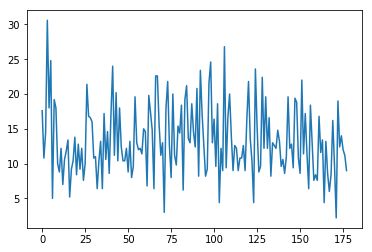

In [73]:
plt.plot(np.mean(np.array(rewards),axis=1))
plt.show()

In [ ]:
P_0=np.eye(4)
Q = np.eye(4)
R = np.array([[1]])
def testing_FDRE(P,A,B,X,Q,R):
    T = np.eye(4)-(2/np.matmul(X.T,X))*np.matmul(X,X.T)
    A_hat = -np.matmul(np.matmul(T,A),np.linalg.inv(T))
    B_hat = np.matmul(T,B)
    P_prime = -np.matmul(A_hat.T,P)-np.matmul(P,A_hat)+Q- \
                np.matmul(np.matmul(np.matmul(np.matmul(P,B_hat),np.linalg.inv(R)),B_hat.T),P)
    return P_prime

In [ ]:
testing_FDRE(P_0,A[0],B[0],X[0],Q,R)

In [ ]:
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        if np.linalg.matrix_rank(ct.ctrb(A[i][j],B[i][j])) != 4:
            print(np.linalg.matrix_rank(ct.ctrb(A[i][j],B[i][j])))

In [ ]:
first = [example.z[0,x,0] for x in range(example.z.shape[0])]
second = [example.z[0,x,1] for x in range(example.z.shape[0])]
third = [example.z[0,x,2] for x in range(example.z.shape[0])]
fourth = [example.z[0,x,3] for x in range(example.z.shape[0])]

In [ ]:
plt.plot(first)
plt.plot(second)
plt.plot(third)
plt.plot(fourth)

In [ ]:
noise_magnitude = np.array([0.01,0.1,0.01,0.1])
av_time = []

env = gym.make('Custom_CartPole-v0', thetaacc_error=2, initial_state=1)
g = env.gravity
M = env.masscart
m = env.masspole
l = env.length
Q = np.eye(4)*[10,1,1,1]
R = 1

'''System of equations'''
A = np.array([[0,1,0,0],[0,0,-m*g/M,0],[0,0,0,1],[0,0,(M+m)*g/(l*M),0]])
B = np.array([[0,1/M,0,-1/(l*M)]]).T


'''LQR'''
import time
K,S,E = ct.lqr(A,B,Q,R)
'''Pole Placement'''
#K = ct.place(A,B,np.array([-1.1,-1.2,-1.3,-1.4]))


#env.x_threshold = 5.0
#env.theta_threshold_radians = 10.0


states = [[] for _ in range(5)]
rewards = np.array([0]*5)
for i_episode in range(5):
    observation = env.reset()
    states[i_episode].append(observation)
    for t in range(500):
#         env.render()
        u = -np.dot(K,observation)
        observation, reward, done, info = env.step(u[0])
        states[i_episode].append(observation)
        if done:
            print("Episode finished at time step {}".format(t+1))
            break
        rewards[i_episode]+=1
    print("Episode complete")
env.close()
